# Assignment 4: Named entity recognition

Create a model for Named Entity Recognition for dataset CoNLL 2002.  
Your quality metric = f1_macro

In your solution you should use: RandomForest, Gradient Boosting (xgboost, lightgbm, catboost)   
Tutorials:  
1. https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide
1. https://github.com/catboost/tutorials 

More baselines you beat - better your score
 
baseline 1 [3 points]: 0.0604      random labels  
baseline 2 [5 points]: 0.3966      PoS features + logistic regression  
baseline 3 [8 points]: 0.8122      word2vec cbow embedding + baseline 2 + svm    

[1 point] using feature engineering (creating features not presented in the baselines)

! Your results must be reproducible. You should explicitly set all seeds random_states in yout model.  
! Remember to use proper training pipeline.  

bonus, think about:  
1. [1 point] Why did we select f1 score with macro averaging as our classification quality measure? What other metrics are suitable?   

In [1]:
!wget 'https://www.dropbox.com/s/0nzylhci63vsfcv/data.zip'

--2019-12-02 20:58:34--  https://www.dropbox.com/s/0nzylhci63vsfcv/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0nzylhci63vsfcv/data.zip [following]
--2019-12-02 20:58:35--  https://www.dropbox.com/s/raw/0nzylhci63vsfcv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95f2c120912dcd6abd92cd94b4.dl.dropboxusercontent.com/cd/0/inline/Atdd4GAzip5eawM7ijzQfn0ZblobI8i-uqdbP7FgctuhxWzw-OriE1-sClHF1jYNefCD3AEf7g8T2XvVqgy13qIHjZORaaUs4-rx6AZICXzgWHgCmo2VUKwKhQY2lCs8RgY/file# [following]
--2019-12-02 20:58:35--  https://uc95f2c120912dcd6abd92cd94b4.dl.dropboxusercontent.com/cd/0/inline/Atdd4GAzip5eawM7ijzQfn0ZblobI8i-uqdbP7FgctuhxWzw-OriE1-sClHF1jYNefCD3AEf7g8T2XvVqgy13qIHjZORaaUs4-rx6AZICXzgWHgCmo2VUKwKhQY

In [2]:
!unzip 'data.zip'

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/ner_short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/data/._ner_short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


SEED=1337

In [4]:
df = pd.read_csv('data/ner_short.csv', index_col=0)
df.head()

,next-next-pos,next-next-word,next-pos,next-word,pos,prev-pos,prev-prev-pos,prev-prev-word,prev-word,sentence_idx,word,tag
0,NNS,demonstrators,IN,of,NNS,__START1__,__START2__,__START2__,__START1__,1.0,Thousands,O
1,VBP,have,NNS,demonstrators,IN,NNS,__START1__,__START1__,Thousands,1.0,of,O
2,VBN,marched,VBP,have,NNS,IN,NNS,Thousands,of,1.0,demonstrators,O
3,IN,through,VBN,marched,VBP,NNS,IN,of,demonstrators,1.0,have,O
4,NNP,London,IN,through,VBN,VBP,NNS,demonstrators,have,1.0,marched,O


In [5]:
# number of sentences
df.sentence_idx.max()

1500.0

In [6]:
# class distribution
df.tag.value_counts(normalize=True )

O        0.852828
B-geo    0.027604
B-gpe    0.020935
B-org    0.020247
I-per    0.017795
B-tim    0.016927
B-per    0.015312
I-org    0.013937
I-geo    0.005383
I-tim    0.004247
B-art    0.001376
I-gpe    0.000837
I-art    0.000748
B-eve    0.000628
I-eve    0.000508
B-nat    0.000449
I-nat    0.000239
Name: tag, dtype: float64

In [0]:
# sentence length
tdf = df.set_index('sentence_idx')
tdf['length'] = df.groupby('sentence_idx').tag.count()
df = tdf.reset_index(drop=False)

In [0]:
# encode categorial variables

le = LabelEncoder()
df['pos'] = le.fit_transform(df.pos)
df['next-pos'] = le.fit_transform(df['next-pos'])
df['next-next-pos'] = le.fit_transform(df['next-next-pos'])
df['prev-pos'] = le.fit_transform(df['prev-pos'])
df['prev-prev-pos'] = le.fit_transform(df['prev-prev-pos'])

In [9]:
df.head()

,sentence_idx,next-next-pos,next-next-word,next-pos,next-word,pos,prev-pos,prev-prev-pos,prev-prev-word,prev-word,word,tag,length
0,1.0,18,demonstrators,9,of,18,39,40,__START2__,__START1__,Thousands,O,48
1,1.0,33,have,18,demonstrators,9,18,39,__START1__,Thousands,of,O,48
2,1.0,32,marched,33,have,18,9,18,Thousands,of,demonstrators,O,48
3,1.0,9,through,32,marched,33,18,9,of,demonstrators,have,O,48
4,1.0,16,London,9,through,32,33,18,demonstrators,have,marched,O,48


In [10]:
# splitting
y = LabelEncoder().fit_transform(df.tag)

df_train, df_test, y_train, y_test = model_selection.train_test_split(df, y, stratify=y, 
                                                                      test_size=0.25, random_state=SEED, shuffle=True)
print('train', df_train.shape[0])
print('test', df_test.shape[0])

train 50155
test 16719


In [0]:
# some wrappers to work with word2vec
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from collections import defaultdict

   
class Word2VecWrapper(TransformerMixin):
    def __init__(self, window=5,negative=5, size=300, iter=100, is_cbow=False, random_state=SEED):
        self.window_ = window
        self.negative_ = negative
        self.size_ = size
        self.iter_ = iter
        self.is_cbow_ = is_cbow
        self.w2v = None
        self.random_state = random_state
        
    def get_size(self):
        return self.size_

    def fit(self, X, y=None):
        """
        X: list of strings
        """
        sentences_list = [x.split() for x in X]
        self.w2v = Word2Vec(sentences_list, 
                            window=self.window_,
                            negative=self.negative_, 
                            size=self.size_, 
                            iter=self.iter_,
                            sg=not self.is_cbow_, seed=self.random_state)

        return self
    
    def has(self, word):
        return word in self.w2v

    def transform(self, X):
        """
        X: a list of words
        """
        if self.w2v is None:
            raise Exception('model not fitted')
        return np.array([self.w2v[w] if w in self.w2v else np.zeros(self.size_) for w in X ])
    


In [11]:
%%time
# here we exploit that word2vec is an unsupervised learning algorithm
# so we can train it on the whole dataset (subject to discussion)

sentences_list = [x.strip() for x in ' '.join(df.word).split('.')]

w2v_cbow = Word2VecWrapper(window=5, negative=5, size=300, iter=300, is_cbow=True, random_state=SEED)
w2v_cbow.fit(sentences_list)

CPU times: user 48 s, sys: 451 ms, total: 48.5 s
Wall time: 27.1 s


In [0]:
%%time
# baseline 1 
# random labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier


columns = ['pos','next-pos','next-next-pos','prev-pos','prev-prev-pos']

model = Pipeline([
    ('enc', OneHotEncoder()),
    ('est', DummyClassifier(random_state=SEED)),
])

model.fit(df_train[columns], y_train)

print('train', metrics.f1_score(y_train, model.predict(df_train[columns]), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test[columns]), average='macro'))


train 0.05887736725599869
test 0.060439542712750365
CPU times: user 131 ms, sys: 13 ms, total: 144 ms
Wall time: 160 ms


In [0]:
%%time
# baseline 2 
# pos features + one hot encoding + logistic regression
from sklearn.preprocessing import OneHotEncoder


columns = ['pos','next-pos','next-next-pos','prev-pos','prev-prev-pos']

model = Pipeline([
    ('enc', OneHotEncoder()),
    ('est', LogisticRegressionCV(Cs=5, cv=5, n_jobs=-1, scoring='f1_macro', 
                             penalty='l2', solver='newton-cg', multi_class='multinomial', random_state=SEED)),
])

model.fit(df_train[columns], y_train)

print('train', metrics.f1_score(y_train, model.predict(df_train[columns]), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test[columns]), average='macro'))

In [0]:
%%time
# baseline 3
# use word2vec cbow embedding + baseline 2 + svm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
import scipy.sparse as sp

embeding = w2v_cbow
encoder_pos = OneHotEncoder()
X_train = sp.hstack([
    embeding.transform(df_train.word),
    embeding.transform(df_train['next-word']),
    embeding.transform(df_train['next-next-word']),
    embeding.transform(df_train['prev-word']),
    embeding.transform(df_train['prev-prev-word']),
    encoder_pos.fit_transform(df_train[['pos','next-pos','next-next-pos','prev-pos','prev-prev-pos']])
])
X_test = sp.hstack([
    embeding.transform(df_test.word),
    embeding.transform(df_test['next-word']),
    embeding.transform(df_test['next-next-word']),
    embeding.transform(df_test['prev-word']),
    embeding.transform(df_test['prev-prev-word']),
    encoder_pos.transform(df_test[['pos','next-pos','next-next-pos','prev-pos','prev-prev-pos']])
])

model = model_selection.GridSearchCV(LinearSVC(penalty='l2', multi_class='ovr', random_state=SEED), 
                                    {'C': np.logspace(-4, 0, 5)}, 
                                    cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('train', metrics.f1_score(y_train, model.predict(X_train), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(X_test), average='macro'))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 14.9min finished


train 0.9556044410366434
test 0.7969558492427843
CPU times: user 2min 53s, sys: 1.39 s, total: 2min 54s
Wall time: 17min 47s


# Beating 1st Baseline

In [0]:
from xgboost import XGBClassifier
import scipy as sp

In [0]:
columns = ['pos','next-pos','next-next-pos','prev-pos','prev-prev-pos']

model = Pipeline([
    ('enc', OneHotEncoder()),
    ('xgb', XGBClassifier(random_state=SEED))
])

In [14]:
model.fit(df_train[columns], y_train)

print('train', metrics.f1_score(y_train, model.predict(df_train[columns]), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test[columns]), average='macro'))

train 0.39326124218078107
test 0.3353187957066505


#Beating 2nd Baseline

In [0]:
from sklearn.ensemble import RandomForestClassifier

n_est = [5, 10, 20, 30, 40, 50, 75, 100, 250, 500]
f1_scores = []
for n in n_est:
  model = Pipeline([
    ('enc', OneHotEncoder()),
    ('lgbm', RandomForestClassifier(n_estimators=n, random_state=SEED))
  ])
  model.fit(df_train[columns], y_train)
  f1 = metrics.f1_score(y_test, model.predict(df_test[columns]), average='macro')
  f1_scores.append(f1)

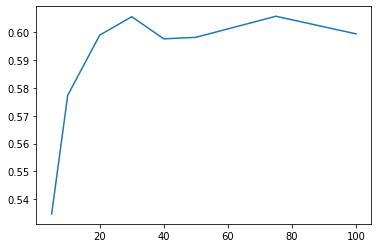

In [16]:
import matplotlib.pyplot as plt

plt.plot(n_est[:-2], f1_scores[:-2])
plt.show()

### Best Parameter: 30 estimators

In [17]:
columns = ['pos','next-pos','next-next-pos','prev-pos','prev-prev-pos']

model = Pipeline([
    ('enc', OneHotEncoder()),
    ('rfc', RandomForestClassifier(n_estimators=30, random_state=SEED)),
])

model.fit(df_train[columns], y_train)

print('train', metrics.f1_score(y_train, model.predict(df_train[columns]), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test[columns]), average='macro'))

train 0.7454657848505839
test 0.6055799325457629


# Question
* F1 was chosen because it combines two main metrics - precision and recall, which shows us both the number of correctly predicted positive labels divided by real right labels, and the number of correctly predicted positive labels divided by all predicted positive labels.
* `weighted` is chosen because it demonstrates the "grouping" of the predicted labels. We could use other `average` parameter, e.g. `macro`, which will not show grouping.